## Classification

In [1]:
import torch
import torch.utils.data
import torch.utils.data as data_utils
import torchvision.transforms as transforms
import pickle as pkl
import pandas as pd
import torch
 
from tqdm import tqdm
from importlib import import_module
import shutil
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import logging
from torch.nn.utils.rnn import pad_sequence
import pickle as pkl
import cv2
import logging
import math
import functools
import torch.nn as nn
from torch.nn import init
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import Parameter as P

class CustomDataset(data_utils.Dataset):
 
    def __init__(self):
  

        with open("C:/DOWLOAD/testKafka/data.pkl", "rb") as f:
            data = pkl.load(f)

        self.word_data = data["word_data"]
        self.idx_to_id = {i: w_id for i, w_id in enumerate(self.word_data.keys())}
        self.T = transforms.Compose(
            [transforms.Resize(64), transforms.Normalize(mean=[0.5], std=[0.5]),transforms.CenterCrop(64),]
        )
        
         
    def __len__(self):
        return len(self.word_data)

    def __getitem__(self, idx):
        item = {}
        w_id = self.idx_to_id[idx]

        # Get image and label
        lab, img = self.word_data[w_id]

        img = self.T(img)

        item["img"] = img.float()
        item["label"] = torch.tensor(lab)


        return item

dataset = CustomDataset()
import torchvision
dataloaders = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=0)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25536\2988174177.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["label"] = torch.tensor(lab)


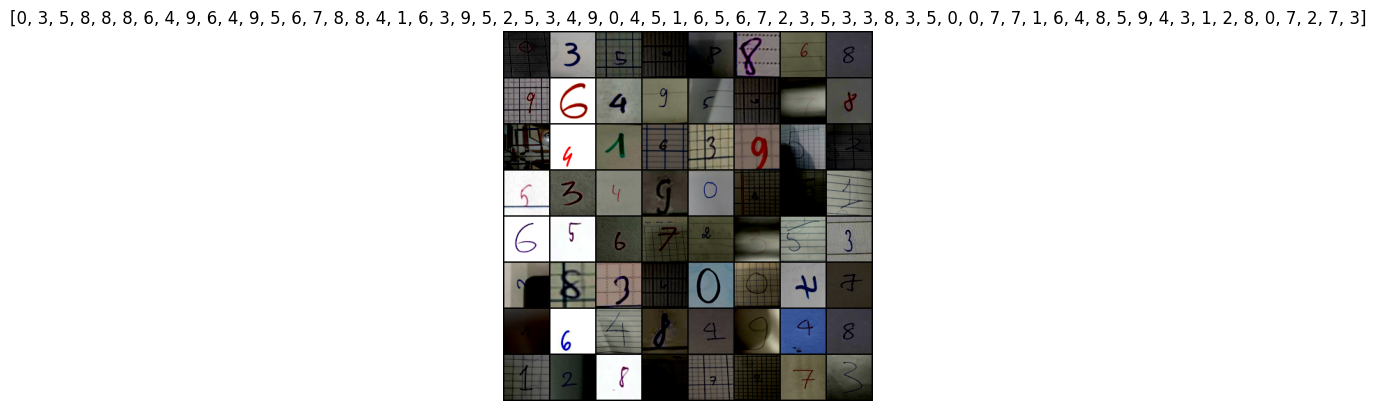

In [2]:
def imshow(inp, title=None):   
    inp = inp.numpy()
 
    inp = np.transpose(inp, (1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()


batch = next(iter(dataloaders))
inputs = batch["img"]
classes = batch["label"]
 
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[int(x) for x in classes])

In [3]:
print(len(dataset))

6349


C:\Users\ASUS\AppData\Local\Temp\ipykernel_25536\2988174177.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["label"] = torch.tensor(lab)


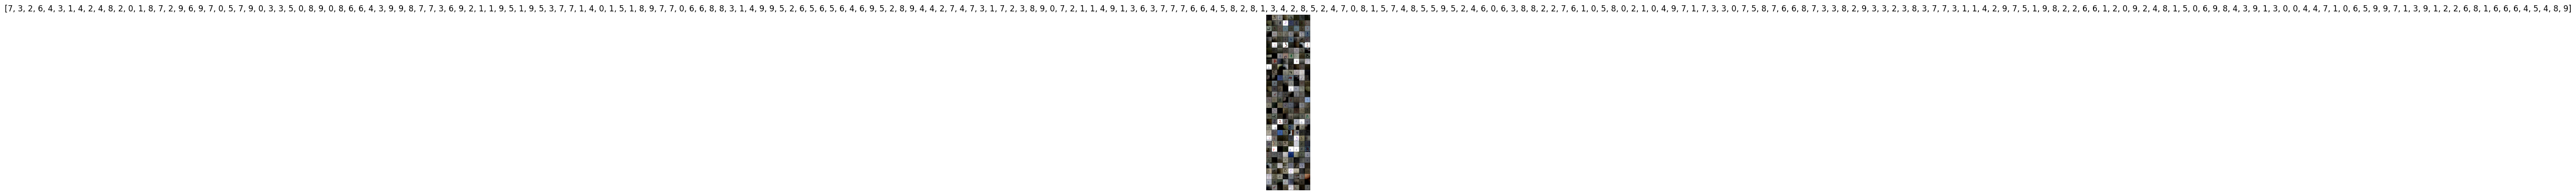

In [4]:
import torchvision
dataloaders = dataloaders = torch.utils.data.DataLoader(dataset, batch_size=256, shuffle=True, num_workers=0)

       
def imshow(inp, title=None):
   
    inp = inp.numpy()
 
    inp = np.transpose(inp, (1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.show()


batch = next(iter(dataloaders))
inputs = batch["img"]
classes = batch["label"]
 
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[int(x) for x in classes])

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()   # interactive mode

In [6]:
device = "cuda"
model_ft = models.resnet34(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\ASUS/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:23<00:00, 3.69MB/s]


In [7]:
from tqdm import tqdm
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for batch in tqdm(dataloaders):
                    inputs = batch["img"].to(device)
                    labels = batch["label"].to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item()
     
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / len(dataloaders)
                

                print(f'{phase} Loss: {epoch_loss:.4f}')

                torch.save(model.state_dict(), best_model_params_path)
    return model

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=1)

Epoch 0/0
----------


  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Temp\ipykernel_25536\2988174177.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item["label"] = torch.tensor(lab)
100%|██████████| 25/25 [00:06<00:00,  3.97it/s]

train Loss: 2.3364


In [9]:
# import zipfile
# with zipfile.ZipFile("C:/DOWLOAD/testKafka/data.2025.zip", "r") as zip_ref:  
#     zip_ref.extractall("/kaggle/working/data.2025")

In [10]:
data_dir = "C:/DOWLOAD/testKafka/kaggle/working/data.2025"
file = os.listdir(data_dir)
print(file[0])

000300afd862e8092248f343a27cdd75.jpg


In [11]:
class CustomDataset(data_utils.Dataset):
 
    def __init__(self):
  

        with open("C:/DOWLOAD/testKafka/data.pkl", "rb") as f:
            data = pkl.load(f)

        self.word_data = data["word_data"]
        self.idx_to_id = {i: w_id for i, w_id in enumerate(self.word_data.keys())}
        self.T = transforms.Compose(
            [
            transforms.RandomInvert()]
        )
         

    def __len__(self):
        return len(self.word_data)

    def __getitem__(self, idx):
        item = {}
        w_id = self.idx_to_id[idx]

        # Get image and label
        lab, img = self.word_data[w_id]

        # img = self.T(img)

        item["img"] = img.float()
        item["label"] = torch.tensor(lab)


        return item

dataset = CustomDataset()


In [12]:
import pickle as pkl
file_path = 'data.pkl'
with open(file_path , "wb") as f:
    pkl.dump({'word_data': dataset}, f, protocol=pkl.HIGHEST_PROTOCOL)

In [13]:
 
from PIL import Image
import torchvision.transforms as transforms

trans = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
data = {}
idx = 0
data_dir = "C:/DOWLOAD/testKafka/kaggle/working/data.2025"
file = os.listdir(data_dir)
print(file[0])
for i in file:
    path = os.path.join(data_dir,i)
    try:
        image = Image.open(path).convert("RGB") 
        image = trans(image)
        data[idx] = [image]
        idx += 1
    except Exception as e:
        print(f"[Lỗi] {i}: {e}")
# for batch in tqdm(dataloaders):
#     inputs = batch["img"].to(device)
#     labels = batch["label"].to(device)
        
#     outputs = model(inputs)
#     _, preds = torch.max(outputs, 1)


000300afd862e8092248f343a27cdd75.jpg
[Lỗi] 004d39d8a48b484ba47ac058af0307d2.HEIC: cannot identify image file 'C:\\DOWLOAD\\testKafka\\kaggle\\working\\data.2025\\004d39d8a48b484ba47ac058af0307d2.HEIC'
[Lỗi] 02c41345f52a4c87bcf29c0aed37a9ca  -.HEIC: cannot identify image file 'C:\\DOWLOAD\\testKafka\\kaggle\\working\\data.2025\\02c41345f52a4c87bcf29c0aed37a9ca  -.HEIC'
[Lỗi] 057efebffefd1027b89c7a6f2ddd7ec0.HEIC: cannot identify image file 'C:\\DOWLOAD\\testKafka\\kaggle\\working\\data.2025\\057efebffefd1027b89c7a6f2ddd7ec0.HEIC'
[Lỗi] 064e9f0be1e982a8f64ad6410df288c7.HEIC: cannot identify image file 'C:\\DOWLOAD\\testKafka\\kaggle\\working\\data.2025\\064e9f0be1e982a8f64ad6410df288c7.HEIC'
[Lỗi] 0737c18223e6c8110ff767ee27841569.HEIC: cannot identify image file 'C:\\DOWLOAD\\testKafka\\kaggle\\working\\data.2025\\0737c18223e6c8110ff767ee27841569.HEIC'
[Lỗi] 0805481419bb2b520b0f433f5cca66e1.HEIC: cannot identify image file 'C:\\DOWLOAD\\testKafka\\kaggle\\working\\data.2025\\0805481419bb

KeyboardInterrupt: 

## Regression

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso

In [ ]:
df = pd.read_csv('C:/DOWLOAD/testKafka/wecode.data/annonimized.csv')
df.head()

In [ ]:
# Load điểm
df_ck = pd.read_csv('C:/DOWLOAD/testKafka/wecode.data/ck-public.csv')
df_qt = pd.read_csv('C:/DOWLOAD/testKafka/wecode.data/qt-public.csv')
df_th = pd.read_csv('C:/DOWLOAD/testKafka/wecode.data/th-public.csv')

# Gộp điểm
df_scores = df_ck.merge(df_qt, on='hash', how='outer', suffixes=('_CK', '_QT'))
df_scores = df_scores.merge(df_th, on='hash', how='outer').rename(columns={'CK': 'CK', 'QT': 'QT', 'TH': 'TH'})

# Gộp vào wecode
df['hash'] = df["concat('it001', username)"]
df_full = df.merge(df_scores, on='hash', how='inner')  # chỉ lấy sinh viên có điểm thật

In [ ]:
df_full.head(n = 50)

In [ ]:
# Kiểm tra dữ liệu có trùng lặp
df_full.duplicated().any()

In [ ]:
# Kích thước dataset
row, column = df.shape
print(f"Row: {row}, Column: {column}")

In [ ]:
# Kích thước dataset
row, column = df_full.shape
print(f"Row: {row}, Column: {column}")

In [ ]:
df_full.isnull().sum()

In [ ]:
df_full = df_full.dropna(subset=['CK',"diemqt","TH"])

In [ ]:
df_full.isnull().sum()

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["concat('it001',`assignment_id`)"],bins=10)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["concat('it001',`problem_id`)"],bins=10)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["concat('it001', username)"],bins=10)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["is_final"],bins=2)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["status"],bins=4)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["pre_score"],bins=10)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["coefficient"],bins=10)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["concat('it001',`language_id`)"],bins=10)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["CK"],bins=10)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["diemqt"],bins=10)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(df_full["TH"],bins=10)
plt.title("Histogram of Item_Weight")
plt.xlabel("Item_Weight")
plt.ylabel("Frequency")

In [ ]:
# Bước 1: tạo 3 cột đánh dấu trạng thái từng dòng
df_full['submit_late'] = (df_full['pre_score'] == 0).astype(int)
df_full['submit_semi_late'] = ((df_full['pre_score'] > 0) & (df_full['pre_score'] < 10000)).astype(int)
df_full['submit_ontime'] = (df_full['pre_score'] == 10000).astype(int)

# Bước 2: groupby theo sinh viên
df_submit_stats = df_full.groupby('hash').agg(
    num_submit_late = ('submit_late', 'sum'),
    num_submit_semi_late = ('submit_semi_late', 'sum'),
    num_submit_ontime = ('submit_ontime', 'sum')
).reset_index()

In [ ]:
df_full.drop(columns=['late_submit'], inplace=True)

In [ ]:
df_submit_stats

In [ ]:
df_full.head(n = 500)

In [ ]:
df_full['last_weighted_score'] = df_full['is_final'].astype(int) * (df_full['pre_score'] * df_full['coefficient'] / 10000)

In [ ]:
df_full.head(n = 500)

In [ ]:
df_full['is_error'] = (df_full['status'] != 'SCORE').astype(int)
df_full.head()

In [ ]:
df_full['is_success_submit'] = ((df_full['is_final'] == 1) & (df_full['coefficient'] == 100)).astype(int)
df_full.head()

In [ ]:
df_full['created_at'] = pd.to_datetime(df_full['created_at'], format='%m-%d %H:%M:%S', errors='coerce')
df_full.head(n=5)

In [ ]:
# Bước 1: chuẩn hóa thời gian
df_full['created_at'] = pd.to_datetime(df_full['created_at'], format='%m-%d %H:%M:%S', errors='coerce')

# Bước 2: tìm thời điểm bắt đầu làm từng bài (min theo hash + problem)
df_start_time = df_full.groupby(['hash', "concat('it001',`problem_id`)"])['created_at'].min().reset_index()
df_start_time = df_start_time.rename(columns={'created_at': 'assignment_start_time'})

# Bước 3: merge ngược lại để mỗi dòng biết lúc nào bắt đầu assignment đó
df_full = df_full.merge(df_start_time, on=['hash', "concat('it001',`problem_id`)"], how='left')

# Bước 4: tính thời gian làm bài tính đến dòng hiện tại
df_full['time_spent_hours'] = (df_full['created_at'] - df_full['assignment_start_time']).dt.total_seconds() / 3600
df_full.head()

In [ ]:
# Lọc những dòng là lần final nộp cho mỗi assignment
df_final_submits = df_full[df_full['is_final'] == 1].copy()

# Lấy giờ nộp final
df_final_submits['final_hour'] = df_final_submits['created_at'].dt.hour

# Tạo bảng ánh xạ (hash, assignment) → giờ nộp final
df_final_hour_map = df_final_submits[[
    'hash',
    "concat('it001',`problem_id`)",
    'final_hour'
]]

In [ ]:
df_full = df_full.merge(
    df_final_hour_map,
    on=['hash', "concat('it001',`problem_id`)"],
    how='left'
)

In [ ]:
df_full.head(n= 10)

In [ ]:
df_full['submit_weekday'] = df_full['created_at'].dt.dayofweek
df_full.head(n = 5)

In [ ]:
df_full['created_at'] = pd.to_datetime(df_full['created_at'], errors='coerce')
df_full['submit_date'] = df_full['created_at'].dt.date

# Tính khoảng thời gian mỗi ngày mỗi sinh viên
df_daily_time = df_full.groupby(['hash', 'submit_date'])['created_at'].agg(['min', 'max']).reset_index()
df_daily_time['hours_spent'] = (df_daily_time['max'] - df_daily_time['min']).dt.total_seconds() / 3600
df_avg_time = df_daily_time.groupby('hash')['hours_spent'].mean().reset_index()
df_avg_time.columns = ['hash', 'avg_hours_per_day']

In [ ]:
df_full = df_full.merge(df_avg_time, on='hash', how='left')
df_full.head(n=5)

In [ ]:
df_full.info()

In [ ]:
df_working_days = df_full.groupby('hash')['submit_date'].nunique().reset_index()
df_working_days.columns = ['hash', 'total_working_days']
df_full = df_full.merge(df_working_days, on='hash', how='left')
df_full.head()

In [ ]:
df_full.info()

In [ ]:
df_features = df_scores.copy()
df_features.head()

In [ ]:
valid_hashes = df_scores['hash'].unique()
df_filtered = df_full[df_full['hash'].isin(valid_hashes)]
df_submit_counts = df_filtered.groupby('hash').size().reset_index(name='num_total_submissions')
df_features = df_features.merge(df_submit_counts, on='hash', how='left')
df_features.head()

In [ ]:
df_success_submit_count = df_full.groupby('hash')['is_success_submit'].sum().reset_index()
df_success_submit_count.columns = ['hash', 'num_success_submit']
df_features = df_features.merge(df_success_submit_count, on='hash', how='left')


In [ ]:
df_features.head(n = 10)

In [ ]:
df_submit_types = df_full.groupby('hash')[[
    'submit_late',
    'submit_semi_late',
    'submit_ontime'
]].sum().reset_index()

# (Optional) Đổi tên cho rõ ràng
df_submit_types = df_submit_types.rename(columns={
    'submit_late': 'num_submit_late',
    'submit_semi_late': 'num_submit_semi_late',
    'submit_ontime': 'num_submit_ontime'
})
df_features = df_features.merge(df_submit_types, on='hash', how='left')
df_features.head()

In [ ]:
df_avg_last_score = df_full.groupby('hash')['last_weighted_score'].mean().reset_index()
df_avg_last_score.columns = ['hash', 'avg_last_weighted_score']
df_features = df_features.merge(df_avg_last_score, on='hash', how='left')
df_features.head()

In [ ]:
df_error_count = df_full.groupby('hash')['is_error'].sum().reset_index()
df_error_count.columns = ['hash', 'num_error_submissions']
df_features = df_features.merge(df_error_count, on='hash', how='left')
df_features.head()

In [ ]:
df_problem_time = df_full.groupby(['hash', "concat('it001',`problem_id`)"])['created_at'].agg(['min', 'max']).reset_index()
df_problem_time['total_time_hours'] = (df_problem_time['max'] - df_problem_time['min']).dt.total_seconds() / 3600
df_avg_time_per_problem = df_problem_time.groupby('hash')['total_time_hours'].mean().reset_index()
df_avg_time_per_problem.columns = ['hash', 'avg_time_per_problem']
df_features = df_features.merge(df_avg_time_per_problem, on='hash', how='left')
df_features.head()

In [ ]:
def hour_to_period_encoded(hour):
    if pd.isna(hour): return -1  # Không rõ
    if 7 <= hour < 12: return 0   # Đêm
    elif 12 <= hour < 19: return 1  # Sáng
    elif 19 <= hour < 23: return 2  # Chiều
    else: return 3  # Tối
# B1: Gán trực tiếp final_period_encoded từ final_hour
df_final_period = df_full[df_full['final_hour'].notna()].copy()
df_final_period['final_period_encoded'] = df_final_period['final_hour'].apply(hour_to_period_encoded)

# B2: Lấy mode theo hash
def mode_or_first(series):
    modes = series.mode()
    return modes.iloc[0] if not modes.empty else -1  # fallback là "Không rõ"

df_final_encoded_mode = df_final_period.groupby('hash')['final_period_encoded'].apply(mode_or_first).reset_index()

# B3: Gộp vào df_features
df_features = df_features.merge(df_final_encoded_mode, on='hash', how='left')

In [ ]:
df_features.head()

In [ ]:
df_full['submit_weekday'] = df_full['created_at'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df_weekday_counts = df_full.groupby(['hash', 'submit_weekday']).size().unstack(fill_value=0).reset_index()
df_weekday_counts.columns = ['hash'] + [f'num_submit_weekday_{i}' for i in range(7)]
# Hoặc đặt tên thân thiện:
weekday_map = {
    0: 'mon', 1: 'tue', 2: 'wed', 3: 'thu', 4: 'fri', 5: 'sat', 6: 'sun'
}
df_weekday_counts.rename(columns={i: f'num_submit_{name}' for i, name in weekday_map.items()}, inplace=True)
df_features = df_features.merge(df_weekday_counts, on='hash', how='left')
df_features.head()

In [ ]:
df_features = df_features.merge(df_avg_time, on='hash', how='left')
df_features.head()

In [ ]:
df_features.info()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Chuyển các biến mục tiêu về số nếu chưa
df_corr = df_features.copy()
df_corr['CK'] = pd.to_numeric(df_corr['CK'], errors='coerce')
df_corr['diemqt'] = pd.to_numeric(df_corr['diemqt'], errors='coerce')
df_corr['TH'] = pd.to_numeric(df_corr['TH'], errors='coerce')

# Tính ma trận tương quan
target_cols = ['CK', 'diemqt', 'TH']
for target in target_cols:
    plt.figure(figsize=(12, 6))
    corr = df_corr.corr(numeric_only=True)[[target]].sort_values(by=target, ascending=False)
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(f'Tương quan giữa các đặc trưng và {target}')
    plt.show()

In [ ]:
df_f_raw = df_features.copy()

In [ ]:
df_features = df_f_raw

In [ ]:
df_features = df_features.dropna()

In [ ]:
cols_to_scale = [
    'num_total_submissions', 'num_success_submit',
    'num_submit_late', 'num_submit_semi_late', 'num_submit_ontime',
    'avg_last_weighted_score', 'num_error_submissions',
    'avg_time_per_problem', 'avg_hours_per_day',
    'num_submit_weekday_0', 'num_submit_weekday_1', 'num_submit_weekday_2',
    'num_submit_weekday_3', 'num_submit_weekday_4', 'num_submit_weekday_5',
    'num_submit_weekday_6'
]
 


In [ ]:
df_features.head()

In [ ]:
print("Giá trị bị mất sau khi làm sạch:")
print(df_features[['CK', 'diemqt', 'TH']].isna().sum())

print("\nMột số giá trị gốc gây lỗi có thể là:")
for col in ['CK', 'diemqt', 'TH']:
    raw_vals = df_f_raw[col].unique()
    print(f"\n{col}:", [v for v in raw_vals if isinstance(v, str) and not re.match(r'^\s*\d+(\.\d+)?\s*$', v)])


In [ ]:
import re

def clean_score_column(col):
    return (
        df_features[col]
        .astype(str)
        .apply(lambda x: re.sub(r'[^\d\.]', '', x))  # giữ lại số & dấu chấm
        .replace('', np.nan)
        .astype(float)
    )

for col in ['CK', 'diemqt', 'TH']:
    df_features[col] = clean_score_column(col)

In [ ]:
df_features['diemqt'] = df_features['diemqt'].replace('\xa0', 0).astype(float)
df_features['TH'] = df_features['TH'].replace('\xa0', 0).astype(float)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Xử lý dữ liệu
df = df_features.dropna()

X = df.drop(columns=['hash', 'CK', 'diemqt', 'TH'])
y = df['TH']  # hoặc 'diemqt' hoặc 'TH'

# 2. Chuẩn hóa dữ liệu số
X_cat = X[['final_period_encoded']]
X_num = X.drop(columns=['final_period_encoded'])

scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

X_processed = np.hstack([X_num_scaled, X_cat.values])

# 3. Chia dữ liệu train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# 4. Khởi tạo và huấn luyện LightGBM
model = lgb.LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=-1,
    random_state=42
)
model.fit(X_train, y_train)

# 5. Dự đoán và đánh giá
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"✅ MAE: {mae:.4f}")
print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ R² Score: {r2:.4f}")

In [ ]:
# Tìm tất cả cột chứa dạng object (string)
obj_cols = df_features.select_dtypes(include='object').columns

# In ra những cột có ít nhất một giá trị chứa '\xa0'
for col in obj_cols:
    if df_features[col].astype(str).str.contains('\xa0').any():
        print(f"Cột '{col}' có chứa ký tự '\\xa0'")

In [ ]:
# In tất cả các giá trị duy nhất trong diemqt chứa '\xa0'
print("Các giá trị lỗi trong 'diemqt':")
print(df_features.loc[df_features['diemqt'].astype(str).str.contains('\xa0'), 'diemqt'].unique())

print("\nCác giá trị lỗi trong 'TH':")
print(df_features.loc[df_features['TH'].astype(str).str.contains('\xa0'), 'TH'].unique())
